## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset3, AugTextDataset
from bert import CustomBert3, CustomBert5, CustomBert3b
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from sentence_embed import get_use_embedding_features, get_distill_bert_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, FocalLoss
from inference import infer
from eda import eda
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
# train['question'] = train['question_title'] + ' [SEP] ' + train['question_body']
# test['question'] = test['question_title'] + ' [SEP] ' + test['question_body']

In [4]:
%%time
init_seed()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
ids_train = {}
ids_test = {}
num_aug = 4
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text in INPUTS:
        ids = {i: [] for i in range(num_aug+1)}
        for x in tqdm(df[text].values):
            if len(x.split(' ')) > 10:
                augs = eda(x, alpha_sr=0.05, alpha_ri=0.05, alpha_rs=0.05, p_rd=0.05, num_aug=num_aug)[:-1]
                augs = [x] + augs
            else:
                augs = (num_aug + 1) * [x]
            encoded_inputs = []
            for i, aug in enumerate(augs):
                encoded_inputs = tokenizer.encode_plus(
                    aug, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True)['input_ids']
                ids[i] += [encoded_inputs]
        if mode == 'train': ids_train[text] = [np.array(aug_ids) for aug_ids in ids.values()]
        else: ids_test[text]  = [np.array(aug_ids) for aug_ids in ids.values()]

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



CPU times: user 2min 23s, sys: 1.08 s, total: 2min 24s
Wall time: 2min 24s


In [5]:
for mode, ids in [('train', ids_train), ('test', ids_test)]:
    question_ids = {i: [] for i in range(num_aug+1)}
    for i in tqdm(range(len(ids['question_title'][0]))):
        for j, aug in enumerate(augs):
            qt_ids = ids['question_title'][j][i]
            qb_ids = ids['question_body'][j][i]
            q_ids = np.concatenate((qt_ids[qt_ids!=0], qb_ids[1:]))[:max_seq_len]
            question_ids[j].append(q_ids)
    if mode == 'train': ids_train['question'] = [np.array(aug_ids) for aug_ids in question_ids.values()]
    else: ids_test['question']  = [np.array(aug_ids) for aug_ids in question_ids.values()]
# %%time
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# ids_train = {}
# ids_test = {}
# max_seq_len = 512
# for mode, df in [('train', train), ('test', test)]:
#     for text in ['question', 'answer']:
#         ids = []
#         for x in tqdm(df[text].values):
#             encoded_inputs = tokenizer.encode_plus(
#                 x, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True)
#             ids.append(encoded_inputs['input_ids'])
#         if mode == 'train': ids_train[text] = np.array(ids)
#         else: ids_test[text] = np.array(ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [7]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
y = train[TARGETS].values.astype(np.float32)

In [9]:
num_workers = 10
bs = 4

In [10]:
bs_test = 4
test_loader = DataLoader(
    AugTextDataset(cat_features_test, ids_test['question'], ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [11]:
class MyRankingLoss(nn.MSELoss):
    def forward(self, input, target):
        input = torch.sigmoid(input)
        n = input.size(0)
        n_pairs = n // 2
        n_tot_pairs = n_pairs + (n % 2)
        loss = 0
        for i in range(n_pairs):
            dp = input[2*i] - input[(2*i)+1]
            dy = target[2*i] - target[(2*i)+1]
            loss += super().forward(dp, dy) / n_tot_pairs
            
        if n_tot_pairs > n_pairs:
            dp = input[-2] - input[-1]
            dy = target[-2] - target[-1]
            loss += super().forward(dp, dy) / n_tot_pairs
        return loss
    
class MixedLoss(nn.Module):
    def __init__(self, pos_weight=N_TARGETS*[1.0]):
        super().__init__()
        pos_weight = torch.Tensor(pos_weight).cuda()
        self.bce = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)
        self.mrl = MyRankingLoss()

    def forward(self, input, target):
        loss = (1. * self.bce(input, target) + 1. * self.mrl(input, target))
        return loss.mean()

In [12]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 2
weight_decay = 0.01
model_name = 'double_distil_bert'
checkpoint_dir = 'checkpoints/'
early_stopping = None

In [13]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.q_bert, lr / 100, weight_decay)
        + get_optimizer_param_groups(model.a_bert, lr / 100, weight_decay)
    )

Fold 1 started at Sun Jan  5 17:58:21 2020
CustomBert3(
  (q_bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn):

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


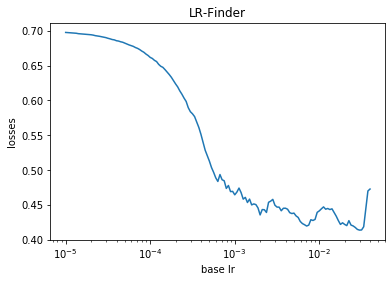

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.43076 - spearmanr 0.17935
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38528 - spearmanr 0.35542
best model: epoch 0 - 0.35542
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37349 - spearmanr 0.357
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.37131 - spearmanr 0.39019


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 1 - 0.39019
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35762 - spearmanr 0.42683
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36871 - spearmanr 0.41238
best model: epoch 2 - 0.41238
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34753 - spearmanr 0.47444
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36805 - spearmanr 0.42005
best model: epoch 3 - 0.42005
TRAINING END: Best score achieved on epoch 3 - 0.42005
Starting inference for model: checkpoints/double_distil_bert_fold_1_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_1_best.pth



Fold 2 started at Sun Jan  5 18:16:56 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.42604 - spearmanr 0.18607
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.39099 - spearmanr 0.33115
best model: epoch 0 - 0.33115
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37259 - spearmanr 0.36382
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.37152 - spearmanr 0.3817
best model: epoch 1 - 0.3817
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35683 - spearmanr 0.42972
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36773 - spearmanr 0.40637
best model: epoch 2 - 0.40637
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34609 - spearmanr 0.48566
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36732 - spearmanr 0.41413
best model: epoch 3 - 0.41413
TRAINING END: Best score achieved on epoch 3 - 0.41413
Starting inference for model: checkpoints/double_distil_bert_fold_2_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_2_best.pth



Fold 3 started at Sun Jan  5 18:35:08 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.42688 - spearmanr 0.1835
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38223 - spearmanr 0.34973
best model: epoch 0 - 0.34973
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37348 - spearmanr 0.36029
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.36862 - spearmanr 0.39118
best model: epoch 1 - 0.39118
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35807 - spearmanr 0.42959
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36399 - spearmanr 0.42514
best model: epoch 2 - 0.42514
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.3473 - spearmanr 0.47966
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36332 - spearmanr 0.42852
best model: epoch 3 - 0.42852
TRAINING END: Best score achieved on epoch 3 - 0.42852
Starting inference for model: checkpoints/double_distil_bert_fold_3_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_3_best.pth



Fold 4 started at Sun Jan  5 18:53:24 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.42679 - spearmanr 0.18985
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.3793 - spearmanr 0.34077
best model: epoch 0 - 0.34077
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37338 - spearmanr 0.35999
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.37141 - spearmanr 0.38322
best model: epoch 1 - 0.38322
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35833 - spearmanr 0.42814
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36426 - spearmanr 0.42638
best model: epoch 2 - 0.42638
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34762 - spearmanr 0.48279
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36366 - spearmanr 0.44016
best model: epoch 3 - 0.44016
TRAINING END: Best score achieved on epoch 3 - 0.44016
Starting inference for model: checkpoints/double_distil_bert_fold_4_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_4_best.pth



Fold 5 started at Sun Jan  5 19:11:43 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.42525 - spearmanr 0.19288
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38396 - spearmanr 0.337
best model: epoch 0 - 0.337
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37227 - spearmanr 0.36216
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.37118 - spearmanr 0.3787
best model: epoch 1 - 0.3787
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35743 - spearmanr 0.42849
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.37025 - spearmanr 0.38534
best model: epoch 2 - 0.38534
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34639 - spearmanr 0.48151
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36808 - spearmanr 0.39768
best model: epoch 3 - 0.39768
TRAINING END: Best score achieved on epoch 3 - 0.39768
Starting inference for model: checkpoints/double_distil_bert_fold_5_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_5_best.pth



OOF score: 0.4160282852143206


In [14]:
init_seed()
folds = GroupKFold(n_splits=5).split(
    X=train['question_body'], groups=train['question_body'])#KFold(n_splits=5, random_state=42).split(train)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        AugTextDataset(cat_features_train, ids_train['question'], ids_train['answer'], train_index, targets=y),
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        AugTextDataset(cat_features_train, ids_train['question'], ids_train['answer'], valid_index, p_aug=0.0, 
                       targets=y), batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / 5
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#0.4160


In [15]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

from scipy.stats import spearmanr
def spearmanr_np(preds, targets):
    score = 0
    for i in range(N_TARGETS):
        score_i = spearmanr(preds[:, i], targets[:, i]).correlation
        score += np.nan_to_num(score_i / N_TARGETS)
    return score

In [16]:
zero_idx = np.where(y.mean(axis=0).round(3)<=0.001)[0][0]

In [17]:
my_round(oofs, 3, 2), oofs

(array([[0.96, 0.69, 0.15, ..., 0.09, 0.87, 0.9 ],
        [0.96, 0.75, 0.03, ..., 0.03, 0.51, 0.96],
        [0.93, 0.54, 0.  , ..., 0.18, 0.57, 0.96],
        ...,
        [0.87, 0.48, 0.  , ..., 0.15, 0.27, 0.84],
        [0.93, 0.6 , 0.51, ..., 0.06, 0.87, 0.96],
        [0.96, 0.78, 0.03, ..., 0.03, 0.9 , 0.93]]),
 array([[0.96855789, 0.6917938 , 0.16137502, ..., 0.08313392, 0.85503227,
         0.91329616],
        [0.97222781, 0.76236659, 0.02143496, ..., 0.031343  , 0.49547711,
         0.94593102],
        [0.92423648, 0.53300953, 0.00549079, ..., 0.18676168, 0.55905312,
         0.94563305],
        ...,
        [0.85946244, 0.48264191, 0.0030839 , ..., 0.14201605, 0.25694215,
         0.84081572],
        [0.93232501, 0.60034025, 0.50237077, ..., 0.0730707 , 0.85558885,
         0.94628507],
        [0.94739544, 0.79286706, 0.03588042, ..., 0.02037646, 0.91138244,
         0.93186194]]))

In [18]:
spearmanr_np(oofs, y)

0.3990345986917042

In [1]:
spearmanr_np(np.clip(round_preds(oofs, high_num=3), 0.00001, 0.999999), y)

NameError: name 'spearmanr_np' is not defined

In [20]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [21]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.934233,0.732784,0.229782,0.427587,0.742702,0.600648,0.686122,0.677616,0.646554,0.001913,0.546884,0.524166,0.013364,0.163897,0.005989,0.013727,0.081520,0.119696,0.787043,0.000660,0.917633,0.859597,0.496107,0.923034,0.934820,0.742635,0.006125,0.032257,0.770316,0.889988
1,46,0.881158,0.500726,0.003538,0.763251,0.742687,0.903758,0.565734,0.481752,0.109084,0.002567,0.505243,0.451234,0.002330,0.000682,0.000209,0.005305,0.882644,0.196897,0.083521,0.000056,0.684422,0.955490,0.650540,0.977428,0.987113,0.883563,0.934870,0.126304,0.050314,0.897678
2,70,0.929240,0.635803,0.007562,0.793745,0.940108,0.967960,0.612074,0.511889,0.285506,0.000447,0.154225,0.794856,0.005458,0.020140,0.001422,0.004806,0.076107,0.060405,0.652227,0.000176,0.873449,0.931848,0.579478,0.969635,0.973642,0.849375,0.019719,0.043913,0.891693,0.905727
3,132,0.870970,0.405283,0.002487,0.699057,0.732973,0.912033,0.534552,0.420190,0.085229,0.007880,0.546324,0.046600,0.001074,0.001337,0.000219,0.002610,0.846192,0.203070,0.507645,0.000075,0.678472,0.957479,0.709795,0.973039,0.985931,0.903248,0.850401,0.196024,0.665560,0.899470
4,200,0.929841,0.454357,0.018955,0.844371,0.851103,0.923067,0.656891,0.641318,0.135677,0.013338,0.282629,0.291918,0.009483,0.018012,0.004508,0.044502,0.182111,0.110708,0.602854,0.001815,0.713363,0.914967,0.675359,0.966175,0.964780,0.847033,0.210585,0.135308,0.640734,0.912286
